In [1]:
import os
import sys

# Set working directory
plant_clef_root = '/home/ffw/workspace/plantCLEF/'
os.chdir(plant_clef_root)

data_dir = os.path.join(plant_clef_root, 'data')

import numpy as np
import sklearn
import scipy
import scipy.misc
import time
import logging
import tempfile
import pprint

import matplotlib.pyplot as plt
%matplotlib inline

from utilities import *
import mcl

import caffe
from caffe import layers as L
from caffe import params as P
caffe.set_mode_gpu()

import lmdb

from mcl.solvers import tutorial as tutorial_solver
import mcl.nets.scatnet_net
reload(mcl.nets.scatnet_net)
from mcl.nets.scatnet_net import scatnet, gen_prototxt, get_layers_sizes


/home/ffw/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
log_file_path = os.path.join(plant_clef_root, 'data', 'scattering_lmdb.log')


logger = logging.getLogger('ScatnetTransform')
logger.setLevel(logging.INFO)

fh = logging.FileHandler(log_file_path)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s:%(levelname)s: %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

print log_file_path


/home/ffw/workspace/plantCLEF/data/scattering_lmdb.log


In [3]:
data_paths = {}

data_paths['train'] = os.path.join(plant_clef_root, 'data', 'train.txt')
data_paths['test'] = os.path.join(plant_clef_root, 'data', 'test.txt')

output_folders = {}
output_folders['train'] = os.path.join(plant_clef_root, 'data', 'train_scat')
output_folders['test'] = os.path.join(plant_clef_root, 'data', 'test_scat')

output_labels = {}
output_labels['train'] = os.path.join(plant_clef_root, 'data', 'train_labels')
output_labels['test'] = os.path.join(plant_clef_root, 'data', 'test_labels')

mean_output_path = os.path.join(plant_clef_root, 'scat_mean.npy')
mean_output = scipy.load(mean_output_path)

shape = (375, 47, 47)
dtype = 'float32'
nbytes = 4 * np.prod(shape)
    
def normalize(data):
    for i, mn in enumerate(mean_output):
        if mn > 0:
            data[i,...] /= mn
    return data

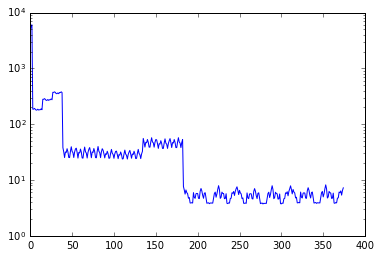

In [4]:
plt.semilogy(mean_output);

In [5]:
convert_to_uint8 = True

# Determine map size for database

In [6]:
k  = '10025'
scat_path = os.path.join(output_folders['train'], "%s.scat" % k)    
s = np.fromfile(scat_path, dtype='float32').reshape(shape)
s = 1-normalize(s)
if convert_to_uint8:
    s = np.uint8(256*s)
datum = caffe.proto.caffe_pb2.Datum()
datum.channels = shape[0]
datum.height = shape[1]
datum.width = shape[2]
datum.data = s.tobytes()  # or .tostring() if numpy < 1.9
datum.label = 24
datum_size_data = len(datum.SerializeToString())

#del datum
#del s



In [7]:
flat_x = np.fromstring(datum.data, dtype=np.uint8)
x = flat_x.reshape(datum.channels, datum.height, datum.width)
x = np.array(x, dtype='float32')

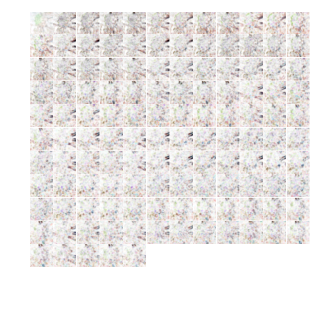

In [8]:
def show_output(output, nangles, max_order, scales, norm_input=True): 
    if norm_input:
        tmp = 1-normalize(output[:,:,:,np.newaxis].copy())
    else:
        tmp = output[:,:,:,np.newaxis].copy()
        
    mask = get_layers_sizes(nangles=nangles, max_order=max_order, scales=scales, nchannels_input=3)
    tmp = np.concatenate([tmp[mask==0],tmp[mask==1],tmp[mask==2]],3)
    vis_square((tmp[0:]))

plt.figure(figsize=(5,5))
show_output(x, 4, 3, range(4), norm_input=False)
#vis_square(x)

In [9]:

for data_set_key in ['test', 'train'][:]:
    output_folder = output_folders[data_set_key]
    data_path = data_paths[data_set_key]
    
    scats = !ls $output_folder
    labels = !cat $data_path
    labels = map(lambda l: l.split(), labels)
    labels = {os.path.splitext(os.path.basename(k))[0]: l for k, l in labels}

    nelements = len(labels)
    map_size  = nelements * datum_size_data
    print "map size for %s is %.1fGB with %i elements" % (data_set_key, map_size * 2**-30, nelements)

    
    lmdb_path = os.path.join(plant_clef_root, 'data', '%s_lmdb_data'%data_set_key)
    lmdb_path_labels = os.path.join(plant_clef_root, 'data', '%s_lmdb_labels'%data_set_key)

    #!rm -dR $lmdb_path
    env = lmdb.open(lmdb_path, map_size=10*map_size)
    env_labels = lmdb.open(lmdb_path_labels)

    cnt = 0
    t0 = time.time()
    txn = env.begin(write=True) 
    txn_labels = env_labels.begin(write=True) 
    for k, l in labels.items()[:nelements]:
        
        # Add to data lmdb
        scat_path = os.path.join(output_folder, "%s.scat" % k)

        s = np.fromfile(scat_path, dtype='float32').reshape(shape)
        s = 1-normalize(s)
        if convert_to_uint8:
            s = np.uint8(256*s)
        datum = caffe.proto.caffe_pb2.Datum()
        datum.channels = shape[0]
        datum.height = shape[1]
        datum.width = shape[2]
        datum.data = s.tobytes()
        datum.label = int(l)
        datum_size = len(datum.SerializeToString())

        str_id = bytes(str(k))
        # The encode is only essential in Python 3
        txn.replace(str_id.encode('ascii'), datum.SerializeToString())
        
        # Add to label lmdb
        datum = caffe.proto.caffe_pb2.Datum()
        datum.channels, datum.height, datum.width = [1, 1, 1]
        datum.float_data.extend([int(l)])
        datum_size = len(datum.SerializeToString())        
        txn_labels.replace(str_id.encode('ascii'), datum.SerializeToString())                        
        
        cnt += 1
        if not cnt % 100:
            logger.info("%i: %.1f" % (cnt, cnt/(time.time()-t0)))
        
        #if cnt > 1000:
        #    break
        
    txn.commit()
    txn_labels.commit()
    env.close()
    env_labels.close()


map size for test is 6.4GB with 8313 elements
map size for train is 21.8GB with 28195 elements


# Create Label DB

In [13]:
import codecs

species_path = os.path.join(data_dir,'species.txt')
species_lmdb_path = os.path.join(data_dir,'species_lmdb')

species = codecs.open(species_path, 'r').read().split('\n')

env = lmdb.open(species_lmdb_path, map_size=len(species) * 200)

with env.begin(write=True) as txn:
    for i, s in enumerate(species):                
        str_id = bytes(str(i))
        
        datum = caffe.proto.caffe_pb2.Datum()
        datum.width = 1
        datum.height = 1
        datum.channels = 1
        datum.data = bytes(s)
        txn.replace(str_id.encode('ascii'), datum.SerializeToString())

env.close()


In [13]:
os.path.splitext('gesg.txt')[0]

('gesg', '.txt')

In [51]:

N = 1000

# Let's pretend this is interesting data
X = np.zeros((N, 3, 32, 32), dtype=np.uint8)
y = np.zeros(N, dtype=np.int64)

X[1,0,...] = 42
y[1] = 11
 
# We need to prepare the database for the size. We'll set it 10 times
# greater than what we theoretically need. There is little drawback to
# setting this too big. If you still run into problem after raising
# this, you might want to try saving fewer entries in a single
# transaction.
map_size = X.nbytes * 10

!rm -dr mylmdb
env = lmdb.open('mylmdb', map_size=map_size)

with env.begin() as txn:
    # txn is a Transaction object
    tc

In [57]:
import numpy as np
import lmdb
import caffe

print bytes(str(0))

env = lmdb.open('mylmdb', readonly=True)
with env.begin() as txn:
    raw_datum = txn.get(str(-30))

datum = caffe.proto.caffe_pb2.Datum()
datum.ParseFromString(raw_datum)

flat_x = np.fromstring(datum.data, dtype=np.uint8)
x = flat_x.reshape(datum.channels, datum.height, datum.width)
y = datum.label

0


TypeError: object of type 'NoneType' has no len()

In [1]:
with env.begin() as txn:
    cursor = txn.cursor()
    for key, value in cursor:
#        print(key, value)
        break

NameError: name 'env' is not defined

# Investigate DIGITS LMDB

In [2]:
digits_lmdb_path = "/home/ffw/scratch/digits/jobs/20160624-120053-bb9a/train_db"

In [3]:

env = lmdb.open(digits_lmdb_path)
txn = env.begin(write=False)
env.stat()


{'branch_pages': 3L,
 'depth': 3L,
 'entries': 28195L,
 'leaf_pages': 209L,
 'overflow_pages': 705946L,
 'psize': 4096L}

In [4]:
i = 0

with env.begin() as txn:
    cursor = txn.cursor()
    for key, value in cursor:
        print key, len(value)
        datum = caffe.proto.caffe_pb2.Datum()
        datum.ParseFromString(value)
        i += 1
        if i > 10:            
            break

00000000_895 113670
00000001_339 119197
00000002_940 114261
00000003_539 92903
00000004_818 115475
00000005_80 65408
00000006_866 51107
00000007_822 77689
00000008_276 139910
00000009_580 106009
00000010_529 112359


In [10]:
help(datum)

Help on Datum in module caffe.proto.caffe_pb2 object:

class Datum(google.protobuf.message.Message)
 |  Method resolution order:
 |      Datum
 |      google.protobuf.message.Message
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  ByteSize(self)
 |  
 |  Clear(self)
 |  
 |  ClearField(self, field_name)
 |  
 |  FindInitializationErrors(self)
 |      Finds required fields which are not initialized.
 |      
 |      Returns:
 |        A list of strings.  Each string is a path to an uninitialized field from
 |        the top-level message, e.g. "foo.bar[5].baz".
 |  
 |  HasField(self, field_name)
 |  
 |  IsInitialized(self, errors=None)
 |      Checks if all required fields of a message are set.
 |      
 |      Args:
 |        errors:  A list which, if provided, will be populated with the field
 |                 paths of all missing required fields.
 |      
 |      Returns:
 |        True iff the specified message has all required fields set.
 |  
 |  ListFields(s

In [12]:
datum.channels

3